# **Face Recognition**

Facial Recognition System is a technology capable of matching a human face from a digital image or a video frame against a database of faces, typically employed to authenticate users through ID verification services, works by pinpointing and measuring facial features from a given image.

We'll be building a face recognition model that uses Siamese Networks to give us a distance value that indicates whether 2 images are same or different.

The Dataset
We'll be using the Extracted Faces from face-recognition-dataset, which is derived from the LFW Dataset. The Extracted Faces contains faces extracted from the base images using Haar-Cascade Face-Detection (CV2).

* The dataset contains 1324 different individuals, with 2-50 images per person.
* The images are of size (128,128,3) and are encoded in RGB.
* Each folder and image is named with a number, i.e 0.jpg, 1.jpg

In [1]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.6.2', '1.20.3')

In [2]:
train_dir = r'/kaggle/working/cv-project-dataset/Train/images'
val_dir = r'/kaggle/working/cv-project-dataset/Val/images'

In [3]:
train_dir ='/kaggle/input/cv-project-dataset/Project Data/Train/images'
val_dir = '/kaggle/input/cv-project-dataset/Project Data/Val/images'

In [4]:
import os
import numpy as np

def preprocess_new_image(img_path):
    # Example image preprocessing (replace this with your actual preprocessing logic)
    import cv2
    image = cv2.imread(img_path)
    image = cv2.resize(image, (224, 224))  # Resize to a fixed size
    # Normalize pixel values to [0, 1]
    # image = image / 255.0
    # Apply sharpening filter
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])  # Sharpening kernel
    sharpened_image = cv2.filter2D(image, -1, kernel)
    sharpened_image=sharpened_image/ 255.0
    return sharpened_image

def load_images(folder_path):
    all_diseases = sorted(os.listdir(folder_path))
    data_list = []  # Initialize the list to store (image, label) tuples
    
    for class_label in all_diseases:
        class_path = os.path.join(folder_path, class_label)
        if os.path.isdir(class_path):  # Check if it's a folder
            # Extract plant name from the folder name
            if "___" in class_label:
                plant_name = class_label.split("___")[0]
                # print(class_label)
            else:
                print(f"Warning: Unexpected folder name format: {class_label}")
                continue

            # Process each image in the folder
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                
                # Validate file extensions (e.g., .jpg, .png)
                valid_extensions = (".jpg", ".jpeg", ".png", ".bmp")
                if not filename.lower().endswith(valid_extensions):
                    continue
                # print(plant_name)
                # Preprocess the image
                img_array = preprocess_new_image(img_path)
                
                # Append (image, label) tuple to the list
                data_list.append((img_array, plant_name))
                
    
    # Return the list of (image, label) tuples
    return data_list


# Example Usage
# train_dir = train_dir  # Update this path
train_data = load_images(train_dir)












In [5]:
val_data= load_images(val_dir)

Label: Cherry_(including_sour)


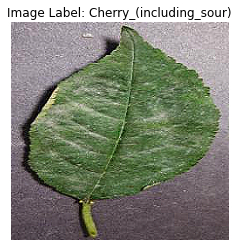

In [6]:
index = 166 # Change this to select a different image
image, label = train_data[index]

# Print the label
print(f"Label: {label}")

# Display the image using Matplotlib
# Display the image using Matplotlib
image_uint8 = (image * 255).astype(np.uint8)  # Convert to uint8
image_rgb = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display
plt.imshow(image_rgb)
plt.title(f"Image Label: {label}")
plt.axis("off")
plt.show()

Label: Apple


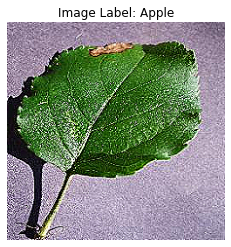

In [7]:
index =  15# Change this to select a different image
image, label = val_data[index]

# Print the label
print(f"Label: {label}")

# Display the image using Matplotlib
  # Convert to uint8
image_uint8 = (image * 255).astype(np.uint8)
image_rgb = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display
plt.imshow(image_rgb)
plt.title(f"Image Label: {label}")
plt.axis("off")
plt.show()

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,ResNet101
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [9]:
def preprocess_data(data, target_size=(224, 224), class_mapping=None):
    processed_images = []
    processed_labels = []

    # Iterate over the dataset to resize images and handle labels
    for item in data:
        image, label = item  # Unpack the tuple

        # Resize image to the target size
        resized_image = tf.image.resize(image, target_size).numpy()
        processed_images.append(resized_image)

        # Map string label to integer using the class_mapping
        if class_mapping is not None:
            if label not in class_mapping:
                raise ValueError(f"Label '{label}' not found in class_mapping.")
            processed_labels.append(class_mapping[label])
        else:
            processed_labels.append(label)

    # Convert images and labels to numpy arrays
    images = np.array(processed_images)
    labels = np.array(processed_labels)
    
    return images, labels

In [10]:
# Define your class mapping
class_mapping = {
    "Apple": 0,
    "Cherry_(including_sour)": 1,
    "Corn_(maize)": 2,
    "Grape": 3,
    "Peach": 4,
    "Pepper,_bell": 5,
    "Potato": 6,
    "Strawberry": 7,
    "Tomato": 8
}


# Preprocess the training and validation data
train_images, train_labels = preprocess_data(train_data, target_size=(224, 224), class_mapping=class_mapping)
val_images, val_labels = preprocess_data(val_data, target_size=(224, 224), class_mapping=class_mapping)
print(np.unique(train_labels))






[0 1 2 3 4 5 6 7 8]


In [11]:
import time
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Clear session
tf.keras.backend.clear_session()

# Load the base MobileNet model without the top fully connected layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(9, activation='softmax')(x)  # Output layer for 9 classes

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers to prevent retraining
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Compute class weights (optional, for imbalanced data)
classes = np.unique(train_labels)  # Replace train_labels with actual training labels
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# --- Measure Training Time ---
start_train = time.time()
history = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=16,
    validation_data=(val_images, val_labels),
    class_weight=class_weights_dict
)
end_train = time.time()
train_time = end_train - start_train
print(f"Training Time: {train_time:.2f} seconds")

# --- Measure Testing Time ---
start_test = time.time()
test_loss, test_accuracy = model.evaluate(val_images, val_labels, batch_size=16)
end_test = time.time()
test_time = end_test - start_test

# Print Results
print(f"Testing Time: {test_time:.2f} seconds")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


17235968/17225924 [==============================] - 1s 0us/step
Class weights: {0: 0.9166666666666666, 1: 1.8333333333333333, 2: 0.9166666666666666, 3: 0.9166666666666666, 4: 1.8333333333333333, 5: 1.8333333333333333, 6: 1.2222222222222223, 7: 1.8333333333333333, 8: 0.36666666666666664}
Epoch 1/20
83/83 [==============================] - 10s 26ms/step - loss: 1.0573 - accuracy: 0.6530 - val_loss: 0.4112 - val_accuracy: 0.9091
Epoch 2/20
83/83 [==============================] - 1s 18ms/step - loss: 0.3005 - accuracy: 0.9326 - val_loss: 0.2692 - val_accuracy: 0.9273
Epoch 3/20
83/83 [==============================] - 1s 18ms/step - loss: 0.1762 - accuracy: 0.9712 - val_loss: 0.2179 - val_accuracy: 0.9394
Epoch 4/20
83/83 [==============================] - 2s 18ms/step - loss: 0.1241 - accuracy: 0.9833 - val_loss: 0.1935 - val_accuracy: 0.9545
Epoch 5/20
83/83 [==============================] - 1s 18ms/step - loss: 0.0921 - accuracy: 0.9932 - val_loss: 0.1766 - val_accuracy: 0.9515
Epoch

In [12]:
# model.save("/kaggle/working/MobileNet_saved_model.h5")

In [13]:
# def evaluate_classwise(model, test_dataset, num_classes):
#     # Initialize counters for matches and mismatches per class
#     class_matches = np.zeros(num_classes, dtype=int)
#     class_mismatches = np.zeros(num_classes, dtype=int)
#     total_predictions_per_class = np.zeros(num_classes, dtype=int)

#     # Iterate through the dataset
#     for images, labels in test_dataset:
#         # Get model predictions
#         predicted_probs = model.predict(images)  # Shape: (batch_size, num_classes)
#         predicted_labels = np.argmax(predicted_probs, axis=1)  # Shape: (batch_size,)
        
#         # Ensure labels are in NumPy format
#         labels = labels.numpy()  # Convert integer-encoded labels to NumPy array

#         # Calculate matches and mismatches for each class
#         for i in range(num_classes):
#             class_mask = (labels == i)  # True for images of class i
#             total_predictions_per_class[i] += np.sum(class_mask)  # Count of true class i samples
#             class_matches[i] += np.sum(class_mask & (predicted_labels == i))  # Matches for class i
#             class_mismatches[i] += np.sum(class_mask & (predicted_labels != i))  # Mismatches for class i

#     # Calculate match and mismatch percentages per class
#     class_match_percentage = (class_matches / total_predictions_per_class) * 100
#     class_mismatch_percentage = (class_mismatches / total_predictions_per_class) * 100

#     return class_match_percentage, class_mismatch_percentage

In [14]:
def evaluate_classwise(model, images, labels, num_classes):
    # Initialize counters for matches and mismatches per class
    class_matches = np.zeros(num_classes, dtype=int)
    class_mismatches = np.zeros(num_classes, dtype=int)
    total_predictions_per_class = np.zeros(num_classes, dtype=int)

    # Get model predictions
    predicted_probs = model.predict(images)  # Shape: (num_samples, num_classes)
    predicted_labels = np.argmax(predicted_probs, axis=1)  # Predicted class indices

    # Iterate through each class to calculate matches/mismatches
    for i in range(num_classes):
        class_mask = (labels == i)  # True for samples of class i
        total_predictions_per_class[i] += np.sum(class_mask)  # Total samples of class i
        class_matches[i] += np.sum(class_mask & (predicted_labels == i))  # Matches
        class_mismatches[i] += np.sum(class_mask & (predicted_labels != i))  # Mismatches

    # Calculate match and mismatch percentages
    class_match_percentage = (class_matches / total_predictions_per_class) * 100
    class_mismatch_percentage = (class_mismatches / total_predictions_per_class) * 100

    return class_match_percentage, class_mismatch_percentage

# Call the function
class_match_percentage, class_mismatch_percentage = evaluate_classwise(model, val_images, val_labels, num_classes=9)

# Print the results
print("Class-wise Match and Mismatch Percentages:")
for i in range(9):  # Assuming num_classes = 9
    print(f"Class {i}:")
    print(f"  Match Percentage: {class_match_percentage[i]:.2f}%")
    print(f"  Mismatch Percentage: {class_mismatch_percentage[i]:.2f}%")


Class-wise Match and Mismatch Percentages:
Class 0:
  Match Percentage: 95.00%
  Mismatch Percentage: 5.00%
Class 1:
  Match Percentage: 90.00%
  Mismatch Percentage: 10.00%
Class 2:
  Match Percentage: 100.00%
  Mismatch Percentage: 0.00%
Class 3:
  Match Percentage: 95.00%
  Mismatch Percentage: 5.00%
Class 4:
  Match Percentage: 95.00%
  Mismatch Percentage: 5.00%
Class 5:
  Match Percentage: 100.00%
  Mismatch Percentage: 0.00%
Class 6:
  Match Percentage: 90.00%
  Mismatch Percentage: 10.00%
Class 7:
  Match Percentage: 100.00%
  Mismatch Percentage: 0.00%
Class 8:
  Match Percentage: 97.00%
  Mismatch Percentage: 3.00%


In [15]:
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# import cv2
# import numpy as np

# def preprocess_new_image(image_path, target_size=(224, 224)):
#     """
#     Preprocess the image to prepare it for the model.
#     Args:
#         image_path (str): Path to the new image.
#         target_size (tuple): Target size to resize the image.
#     Returns:
#         np.array: Preprocessed image.
#     """
#     # Load and resize the image
#     image = load_img(image_path, target_size=target_size)
    
#     # Convert the PIL image to a NumPy array
#     image_array = img_to_array(image)  # Shape: (224, 224, 3)
    
#     # Apply sharpening filter using OpenCV
#     kernel = np.array([[0, -1, 0],
#                        [-1, 5, -1],
#                        [0, -1, 0]]) 
#     sharpened_image = cv2.filter2D(image_array.astype(np.uint8), -1, kernel)
    
#     # Normalize pixel values to [0, 1]
#     sharpened_image = sharpened_image / 255.0
    
#     # Expand dimensions to match model input shape: (1, 224, 224, 3)
#     preprocessed_image = np.expand_dims(sharpened_image, axis=0)
    
#     return preprocessed_image

In [16]:
# from sklearn.metrics import accuracy_score
# import numpy as np
# import os

# def load_images(folder_path):
#     all_diseases = sorted(os.listdir(folder_path))
#     images = []
#     labels = []
#     for class_label in all_diseases:
#         class_path = os.path.join(folder_path, class_label)
#         if os.path.isdir(class_path):
#             for filename in os.listdir(class_path):
#                 img_path = os.path.join(class_path, filename)

#                 img_array = preprocess_new_image(img_path)  # Assume this function processes the image correctly
#                 class_label = class_label.split("___")[0]  # Assuming labels are embedded in folder names

#                 images.append(img_array)
#                 labels.append(class_label)
#     return np.vstack(images), np.array(labels)

In [17]:
# # Load test data
# X_test, y_test = load_images('/kaggle/input/cv-project-dataset/Project Data/Val/images')

# # Predict using the model
# y_pred_label = model.predict(X_test)  # Assuming model is preloaded and trained

In [18]:
# # Map predicted numeric labels to class names if needed

# class_mapping = {
#     0: "Apple",
#     1: "Cherry_(including_sour)",
#     2: "Corn_(maize)",
#     3: "Grape",
#     4: "Peach",
#     5: "Pepper,_bell",
#     6: "Potato",
#     7: "Strawberry",
#     8: "Tomato"
# }
# if hasattr(model, "classes"):  # Some sklearn models have classes_ attribute
#     ypred = [model.classes[np.argmax(pred)] for pred in y_pred_label]
# else:
#     y_pred = [class_mapping.get(np.argmax(pred), "Unknown") for pred in y_pred_label]

In [19]:
# # Ensure y_test and y_pred are comparable
# y_pred = np.array(y_pred)
# y_test = np.array(y_test)

# # Calculate accuracy
# for i in range(len(y_test)):

#     print(f"y_test : {y_test[i]} , y_pred : {y_pred[i]}" )

# # print("y_pred (label) :" ,y_pred)
# acc = accuracy_score(y_test, y_pred)
# print("Accuracy:", acc * 100)

## Reading the Dataset
We're reading the folders and splitting them into train and test set for training purposes.

In [20]:
# # Setting random seeds to enable consistency while testing.
# random.seed(5)
# np.random.seed(5)
# tf.random.set_seed(5)

# ROOT = "../input/face-recognition-dataset/Extracted Faces/Extracted Faces"

# def read_image(index):
#     path = os.path.join(ROOT, index[0], index[1])
#     image = cv2.imread(path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     return image

In [21]:
# def split_dataset(directory, split=0.9):
#     folders = os.listdir(directory)
#     num_train = int(len(folders)*split)
    
#     random.shuffle(folders)
    
#     train_list, test_list = {}, {}
    
#     # Creating Train-list
#     for folder in folders[:num_train]:
#         num_files = len(os.listdir(os.path.join(directory, folder)))
#         train_list[folder] = num_files
    
#     # Creating Test-list
#     for folder in folders[num_train:]:
#         num_files = len(os.listdir(os.path.join(directory, folder)))
#         test_list[folder] = num_files  
    
#     return train_list, test_list

# train_list, test_list = split_dataset(ROOT, split=0.9)
# print("Length of training list:", len(train_list))
# print("Length of testing list :", len(test_list))

# # train_list, test list contains the folder names along with the number of files in the folder.
# print("\nTest List:", test_list)


## Creating Triplets
We use the train and test list to create triplets of (anchor, postive, negative) face data, where positive is the same person and negative is a different person than anchor.

In [22]:
# def create_triplets(directory, folder_list, max_files=10):
#     triplets = []
#     folders = list(folder_list.keys())
    
#     for folder in folders:
#         path = os.path.join(directory, folder)
#         files = list(os.listdir(path))[:max_files]
#         num_files = len(files)
        
#         for i in range(num_files-1):
#             for j in range(i+1, num_files):
#                 anchor = (folder, f"{i}.jpg")
#                 positive = (folder, f"{j}.jpg")

#                 neg_folder = folder
#                 while neg_folder == folder:
#                     neg_folder = random.choice(folders)
#                 neg_file = random.randint(0, folder_list[neg_folder]-1)
#                 negative = (neg_folder, f"{neg_file}.jpg")

#                 triplets.append((anchor, positive, negative))
            
#     random.shuffle(triplets)
#     return triplets

In [23]:
# train_triplet = create_triplets(ROOT, train_list)
# test_triplet  = create_triplets(ROOT, test_list)

# print("Number of training triplets:", len(train_triplet))
# print("Number of testing triplets :", len(test_triplet))

# print("\nExamples of triplets:")
# for i in range(5):
#     print(train_triplet[i])

## Creating Batch-Generator¶
Creating a Batch-Generator that converts the triplets passed into batches of face-data and preproccesses it before returning the data into seperate lists.

Parameters:

* Batch_size: Batch_size of the data to return
* Preprocess: Whether to preprocess the data or not

In [24]:
# def get_batch(triplet_list, batch_size=256, preprocess=True):
#     batch_steps = len(triplet_list)//batch_size
    
#     for i in range(batch_steps+1):
#         anchor   = []
#         positive = []
#         negative = []
        
#         j = i*batch_size
#         while j<(i+1)*batch_size and j<len(triplet_list):
#             a, p, n = triplet_list[j]
#             anchor.append(read_image(a))
#             positive.append(read_image(p))
#             negative.append(read_image(n))
#             j+=1
            
#         anchor = np.array(anchor)
#         positive = np.array(positive)
#         negative = np.array(negative)
        
#         if preprocess:
#             anchor = preprocess_input(anchor)
#             positive = preprocess_input(positive)
#             negative = preprocess_input(negative)
        
#         yield ([anchor, positive, negative])

## Plotting the Data
Plotting the data generated from get_batch() to see the results

In [25]:
# num_plots = 6

# f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

# for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
#     a,p,n = x
#     for i in range(num_plots):
#         axes[i, 0].imshow(a[i])
#         axes[i, 1].imshow(p[i])
#         axes[i, 2].imshow(n[i])
#         i+=1
#     break

## Creating the Model
Unlike a conventional CNN, the Siamese Network does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

Siamese Network Image
![](https://miro.medium.com/max/2000/1*05hUCDHhnl4hdjqvdVTHtw.png)

In [26]:
# from tensorflow.keras import backend, layers, metrics

# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.models import Model, Sequential

# from tensorflow.keras.utils import plot_model
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Encoder
The Encoder is responsible for converting the passed images into their feature vectors. We're using a pretrained model, Xception model which is based on Inception_V3 model. By using transfer learning, we can significantly reduce the training time and size of the dataset.

The Model is connected to Fully Connected (Dense) layers and the last layer normalises the data using L2 Normalisation. (L2 Normalisation is a technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1)

In [27]:
# def get_encoder(input_shape):
#     """ Returns the image encoding model """

#     pretrained_model = Xception(
#         input_shape=input_shape,
#         weights='imagenet',
#         include_top=False,
#         pooling='avg',
#     )
    
#     for i in range(len(pretrained_model.layers)-27):
#         pretrained_model.layers[i].trainable = False

#     encode_model = Sequential([
#         pretrained_model,
#         layers.Flatten(),
#         layers.Dense(512, activation='relu'),
#         layers.BatchNormalization(),
#         layers.Dense(256, activation="relu"),
#         layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
#     ], name="Encode_Model")
#     return encode_model

Siamese Network
We're creating a Siamese Network that takes 3 input images, (anchor, postive, negative) and uses the encoder above to encode the images to their feature vectors. Those features are passed to a distance layer which computes the distance between (anchor, positive) and (anchor, negative) pairs.

We'll be defining a custom layer to compute the distance.

Distance Formula:

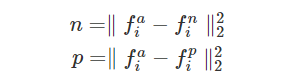

In [28]:
# class DistanceLayer(layers.Layer):
#     # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)

#     def call(self, anchor, positive, negative):
#         ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
#         an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
#         return (ap_distance, an_distance)
    

# def get_siamese_network(input_shape = (128, 128, 3)):
#     encoder = get_encoder(input_shape)
    
#     # Input Layers for the images
#     anchor_input   = layers.Input(input_shape, name="Anchor_Input")
#     positive_input = layers.Input(input_shape, name="Positive_Input")
#     negative_input = layers.Input(input_shape, name="Negative_Input")
    
#     ## Generate the encodings (feature vectors) for the images
#     encoded_a = encoder(anchor_input)
#     encoded_p = encoder(positive_input)
#     encoded_n = encoder(negative_input)
    
#     # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
#     distances = DistanceLayer()(
#         encoder(anchor_input),
#         encoder(positive_input),
#         encoder(negative_input)
#     )
    
#     # Creating the Model
#     siamese_network = Model(
#         inputs  = [anchor_input, positive_input, negative_input],
#         outputs = distances,
#         name = "Siamese_Network"
#     )
#     return siamese_network

# siamese_network = get_siamese_network()
# siamese_network.summary()

In [29]:
# plot_model(siamese_network, show_shapes=True, show_layer_names=True)

## Putting everything together
We now need to implement a model with custom training loop and loss function so we can compute the triplet loss using the three embeddings produced by the Siamese network.

We'll create a Mean metric instance to track the loss of the training process.

Triplet Loss Function:

### ![](https://miro.medium.com/max/1838/0*AX2TSZNk19_gDgTN.png)

In [30]:
# class SiameseModel(Model):
#     # Builds a Siamese model based on a base-model
#     def __init__(self, siamese_network, margin=1.0):
#         super(SiameseModel, self).__init__()
        
#         self.margin = margin
#         self.siamese_network = siamese_network
#         self.loss_tracker = metrics.Mean(name="loss")

#     def call(self, inputs):
#         return self.siamese_network(inputs)

#     def train_step(self, data):
#         # GradientTape get the gradients when we compute loss, and uses them to update the weights
#         with tf.GradientTape() as tape:
#             loss = self._compute_loss(data)
            
#         gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
#         self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
#         self.loss_tracker.update_state(loss)
#         return {"loss": self.loss_tracker.result()}

#     def test_step(self, data):
#         loss = self._compute_loss(data)
        
#         self.loss_tracker.update_state(loss)
#         return {"loss": self.loss_tracker.result()}

#     def _compute_loss(self, data):
#         # Get the two distances from the network, then compute the triplet loss
#         ap_distance, an_distance = self.siamese_network(data)
#         loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
#         return loss

#     @property
#     def metrics(self):
#         # We need to list our metrics so the reset_states() can be called automatically.
#         return [self.loss_tracker]

In [31]:
# siamese_model = SiameseModel(siamese_network)

# optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
# siamese_model.compile(optimizer=optimizer)

## Training the Model
We'll now be training the siamese_model on batches of triplets. We'll print the training loss, along with additional metrics from testing every epoch. The model weights will also be saved whenever it outperforms the previous max_accuracy.

We're hoping to collect more metrics about the model to evaluate how to increase the accuracy of the model. The epochs have been set to avoid going over Kaggle's time constraint.

### Test Function
test_on_triplets() function will be responsible for testing the model on test_triplets. It'll collect metrics (accuracy, means, stds) by predicting on the train data. We'll also be printing the Accuracy of the model after testing.

In [32]:
# def test_on_triplets(batch_size = 256):
#     pos_scores, neg_scores = [], []

#     for data in get_batch(test_triplet, batch_size=batch_size):
#         prediction = siamese_model.predict(data)
#         pos_scores += list(prediction[0])
#         neg_scores += list(prediction[1])
    
#     accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
#     ap_mean = np.mean(pos_scores)
#     an_mean = np.mean(neg_scores)
#     ap_stds = np.std(pos_scores)
#     an_stds = np.std(neg_scores)
    
#     print(f"Accuracy on test = {accuracy:.5f}")
#     return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [33]:
# save_all = False
# epochs = 30
# batch_size = 128

# max_acc = 0
# train_loss = []
# test_metrics = []

# for epoch in range(1, epochs+1):
#     t = time.time()
    
#     # Training the model on train data
#     epoch_loss = []
#     for data in get_batch(train_triplet, batch_size=batch_size):
#         loss = siamese_model.train_on_batch(data)
#         epoch_loss.append(loss)
#     epoch_loss = sum(epoch_loss)/len(epoch_loss)
#     train_loss.append(epoch_loss)

#     print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
#     print(f"Loss on train    = {epoch_loss:.5f}")
    
#     # Testing the model on test data
#     metric = test_on_triplets(batch_size=batch_size)
#     test_metrics.append(metric)
#     accuracy = metric[0]
    
#     # Saving the model weights
#     if save_all or accuracy>=max_acc:
#         siamese_model.save_weights("siamese_model")
#         max_acc = accuracy

# # Saving the model after all epochs run
# siamese_model.save_weights("siamese_model-final")

## Using the Model
Now that we've finished training our model, we need to extract the encoder so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for later use.

In [34]:
# def extract_encoder(model):
#     encoder = get_encoder((128, 128, 3))
#     i=0
#     for e_layer in model.layers[0].layers[3].layers:
#         layer_weight = e_layer.get_weights()
#         encoder.layers[i].set_weights(layer_weight)
#         i+=1
#     return encoder

# encoder = extract_encoder(siamese_model)
# encoder.save_weights("encoder")
# encoder.summary()

## Classify Images
To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [35]:
# def classify_images(face_list1, face_list2, threshold=1.3):
#     # Getting the encodings for the passed faces
#     tensor1 = encoder.predict(face_list1)
#     tensor2 = encoder.predict(face_list2)
    
#     distance = np.sum(np.square(tensor1-tensor2), axis=-1)
#     prediction = np.where(distance<=threshold, 0, 1)
#     return prediction

In [36]:
# def ModelMetrics(pos_list, neg_list):
#     true = np.array([0]*len(pos_list)+[1]*len(neg_list))
#     pred = np.append(pos_list, neg_list)
    
#     # Compute and print the accuracy
#     print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
#     # Compute and plot the Confusion matrix
#     cf_matrix = confusion_matrix(true, pred)

#     categories  = ['Similar','Different']
#     names = ['True Similar','False Similar', 'False Different','True Different']
#     percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

#     labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
#     labels = np.asarray(labels).reshape(2,2)

#     sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
#                 xticklabels = categories, yticklabels = categories)

#     plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
#     plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
#     plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


# pos_list = np.array([])
# neg_list = np.array([])

# for data in get_batch(test_triplet, batch_size=256):
#     a, p, n = data
#     pos_list = np.append(pos_list, classify_images(a, p))
#     neg_list = np.append(neg_list, classify_images(a, n))
#     break

# ModelMetrics(pos_list, neg_list)